In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import FeatureUnion

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
# import catboost as catb

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('course_project_train.csv')
df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [3]:
df['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [5]:
def data_preprocessing(X):

    X['Years in current job'] = X['Years in current job'].replace(regex = True, to_replace = r'\W\s\D+$|\s\D+$', value = '').replace('< 1', 0)
    X.loc[X['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].median()
    X['Years in current job'] = X['Years in current job'].astype('int')

    
    for col in X.select_dtypes(include='object').columns:
        X[col] = X[col].astype('category')

    X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 99999999

    X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].value_counts().idxmax()

#     X.loc[X['Credit Score'] > 999, 'Credit Score'] = X.loc[X['Credit Score'] > 1000, 'Credit Score'] // 10
    
    return X

In [6]:
df = data_preprocessing(df)

In [7]:
df_cat = df.select_dtypes(include='category')
df_num = df.select_dtypes(exclude='category')
df_num = df_num.drop(['Credit Default'], axis = 1)
df_target = df['Credit Default']

In [8]:
## fill nan
imputer = IterativeImputer(max_iter = 100)
imp_arr = pd.DataFrame(imputer.fit_transform(df_num))
imp_arr.columns = df_num.columns
df = pd.concat([df_cat, imp_arr], axis = 1)
df = pd.concat([df, df_target], axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Purpose                       7500 non-null   category
 2   Term                          7500 non-null   category
 3   Annual Income                 7500 non-null   float64 
 4   Years in current job          7500 non-null   float64 
 5   Tax Liens                     7500 non-null   float64 
 6   Number of Open Accounts       7500 non-null   float64 
 7   Years of Credit History       7500 non-null   float64 
 8   Maximum Open Credit           7500 non-null   float64 
 9   Number of Credit Problems     7500 non-null   float64 
 10  Months since last delinquent  7500 non-null   float64 
 11  Bankruptcies                  7500 non-null   float64 
 12  Current Loan Amount           7500 non-null   fl

In [10]:
for cat_colname in df[df.columns].select_dtypes(include = 'category').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



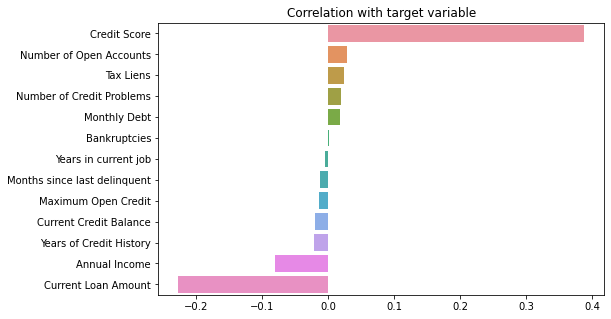

In [11]:
corr_with_target = df[df.columns.drop('Credit Default').tolist() + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable');

Корреляция некоторых фичей с таргетом достаточно сильная, может получиться хорошо разделимое пространство

In [12]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
CAT_FEATURE_NAMES = [col for col in df.select_dtypes(include='category').columns]
NUM_FEATURE_NAMES = [col for col in df.select_dtypes(include='float64').columns]

In [13]:
NUM_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [14]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Purpose                       7500 non-null   category
 2   Term                          7500 non-null   category
 3   Annual Income                 7500 non-null   float64 
 4   Years in current job          7500 non-null   float64 
 5   Tax Liens                     7500 non-null   float64 
 6   Number of Open Accounts       7500 non-null   float64 
 7   Years of Credit History       7500 non-null   float64 
 8   Maximum Open Credit           7500 non-null   float64 
 9   Number of Credit Problems     7500 non-null   float64 
 10  Months since last delinquent  7500 non-null   float64 
 11  Bankruptcies                  7500 non-null   float64 
 12  Current Loan Amount           7500 non-null   fl

In [15]:
#разделим данные на train/test
X = df_norm[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES]
y = df_norm[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5625, 16), (5625,), (1875, 16), (1875,))

In [17]:
model = lgbm.LGBMClassifier(reg_alpha = 1, num_leaves = 16, max_depth = 14, n_estimators = 100, boosting_type = 'goss', random_state = 42)
model.fit(X_train, y_train, categorical_feature = CAT_FEATURE_NAMES)
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1]

C:\Users\snetkova\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', 'Term']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [18]:
res = {}
# res_probs = {}

In [19]:
# def get_classifier_metrics(y_test, y_score):
#     b = 1
#     precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
#     fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
#     # locate the index of the largest f score
#     ix = np.argmax(fscore)

#     roc_auc = roc_auc_score(y_true=y_test, y_score = y_score)
#     return roc_auc, fscore[ix], precision[ix], recall[ix], thresholds[ix]

In [20]:
def evaluate_results(y_test, y_predict):
    f1 = f1_score(y_test, y_predict)
    roc = roc_auc_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict, average='binary')
    prc = precision_score(y_test, y_predict, average='binary')

    return roc, f1, prc, rec

In [21]:
res['labeled_data'] = list(evaluate_results(y_test, y_pred))
res

{'labeled_data': [0.6390969852528642,
  0.4645308924485126,
  0.6506410256410257,
  0.3612099644128114]}

In [22]:
# res_probs['labeled_data'] = list(get_classifier_metrics(y_test, y_pred_probs))
# res

### PU learning

In [23]:
def mod_data(data, p):
    mod_data = data.copy()
    #get the indices of the positives samples
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    #shuffle them
    np.random.shuffle(pos_ind)
    # leave just p% of the positives marked
    pos_sample_len = int(np.ceil(p * len(pos_ind)))
#     print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
    pos_sample = pos_ind[:pos_sample_len]
    
#     mod_data['class_test'] = -1
    mod_data['class_test'] = 0
    mod_data.loc[pos_sample,'class_test'] = 1
#     print('target variable:\n', mod_data.iloc[:,-1].value_counts())
    
    return mod_data

In [24]:
def get_samples(mod_data):
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']== 0][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']== 0][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']== 1]
#     print(neg_sample.shape, pos_sample.shape)
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    
    return sample_train, sample_test

In [25]:
# df_mod = mod_data(df, 0.25)
# df_mod

In [26]:
# x_data = df_mod.drop(['Credit Default', 'class_test'], axis = 1) # just the X 
# y_labeled = df_mod['class_test'] # new class (just the P & U)
# y_positive = df_mod['Credit Default'] # original class
# x_data.shape, y_labeled.shape, y_positive.shape, y_labeled.unique()

In [27]:
# sample_train, sample_test = get_samples(df_mod)

In [28]:
# model.fit(sample_train.drop(['Credit Default', 'class_test'], axis = 1), 
#           sample_train['class_test'], categorical_feature = CAT_FEATURE_NAMES)
# y_predict = model.predict(sample_test.drop(['Credit Default', 'class_test'], axis = 1))
# evaluate_results(sample_test['Credit Default'], y_predict)

In [29]:
for P in [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.8, 0.9]:
    df_mod = mod_data(df, P)
    sample_train, sample_test = get_samples(df_mod)
    model.fit(sample_train.drop(['Credit Default', 'class_test'], axis = 1), sample_train['class_test'], categorical_feature = CAT_FEATURE_NAMES)
    y_predict = model.predict(sample_test.drop(['Credit Default', 'class_test'], axis = 1))
    y_predict_probs = model.predict_proba(sample_test.drop(['Credit Default', 'class_test'], axis = 1))[:, 1]
#     evaluate_results(sample_test['Credit Default'], y_predict)
    
    res['pos_labeled_P=' + format(P)] = list(evaluate_results(sample_test['Credit Default'], y_predict))
#     res_probs['pos_labeled_P=' + format(P)] = list(get_classifier_metrics(sample_test['Credit Default'], y_predict_probs))

C:\Users\snetkova\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', 'Term']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\snetkova\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', 'Term']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\snetkova\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', 'Term']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\snetkova\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Home Ownership', 'Purpose', '

In [30]:
pd.DataFrame.from_dict(res, orient='index', columns = ['roc_auc', 'fscore', 'precision', 'recall'])

,roc_auc,fscore,precision,recall
labeled_data,0.639097,0.464531,0.650641,0.361210
pos_labeled_P=0.1,0.626176,0.457513,0.398387,0.537249
pos_labeled_P=0.2,0.647207,0.466848,0.365057,0.647355
pos_labeled_P=0.3,0.627900,0.420379,0.327515,0.586746
pos_labeled_P=0.4,0.645660,0.415237,0.309091,0.632418
pos_labeled_P=0.5,0.663088,0.393690,0.278475,0.671525
pos_labeled_P=0.6,0.657087,0.345108,0.237298,0.632440
pos_labeled_P=0.7,0.662976,0.285850,0.182757,0.655773
pos_labeled_P=0.8,0.673386,0.226374,0.135348,0.691275
pos_labeled_P=0.9,0.658931,0.123163,0.067954,0.656716


F1 при P = 0.2 получился практически таким же, как и при обучении на данных с полноценной разметкой. Однако, соотношение precision-recall на полуразмеченных данных кардинально отличается: при всех значениях P precision практически вдвое выше, чем recall, то есть наша модель определяет большую часть объектов положительного класса (ткк у нас есть реальные положительные метки), но при этом часто ошибается, причислив к нему неразмеченный объект